In [1]:
from f_drosophila_infer import *
from f_data_prep import *
import seaborn as sns
from sklearn import linear_model
from keras.models import Sequential
from keras.layers import Dense, Activation

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np

In [2]:
matplotlib.rcParams.update({'font.size':20})
matplotlib.rcParams['legend.frameon'] = False

In [3]:
data_all = np.loadtxt('../data_complete.txt')
all_bin = np.vsplit(data_all, 6)
all_init = np.vstack([all_bin[i] for i in range(5)])
all_diff = np.vstack([all_bin[i+1]-all_bin[i] for i in range(5)])

In [4]:
with open('./pickles/validation_cells.pkl', 'rb') as f:
    cells_v = pickle.load(f)

In [5]:
val = np.hstack([cells_v+(6078*i) for i in range(5)])
cells_tt = np.delete(range(6078), cells_v)
tr = np.hstack([cells_tt+(6078*i) for i in range(5)])

cells_20 = np.random.choice(cells_tt, size=1216, replace=False)
tr_20 = np.hstack([cells_20+(6078*i) for i in range(5)])

In [6]:
def make_quad(X):
    quad = np.zeros((int(X.shape[0]), int(X.shape[1] + (X.shape[1]*(X.shape[1]-1))/2)))
    quad[:, :X.shape[1]] = np.copy(X)
    col = X.shape[1]
    for i in range(X.shape[1]-1):
        for j in range(i+1, X.shape[1]):
            quad[:,col] = (X[:,i]*X[:,j])
            col += 1
    return quad

In [8]:
quad = make_quad(all_init)
quad_t = np.copy(quad[tr])
y_t = np.copy(all_diff[tr])
quad_v = np.copy(quad[val])
y_v = np.copy(all_diff[val])

np.save('./numpy_files/quad_t', quad_t)
np.save('./numpy_files/quad_v', quad_v)
for i in range(1,y_t.shape[1]+1):
    np.save('./numpy_files/y_t%s' % i, y_t[:,:i])
    np.save('./numpy_files/y_v%s' % i, y_v[:,:i])


In [8]:
# test=np.load('./numpy_files/y_t99.npy')
# test.shape

In [9]:
# model = Sequential()
# model.add(Dense(99, activation='linear', use_bias=True, input_dim=4950))
# # model.add(Dense(99, activation='linear'))
# model.compile(optimizer='SGD', loss='mean_absolute_error')
# hist = model.fit(quad_t, y_t, batch_size=50, epochs=200, validation_data=(quad_v, y_v), verbose=1)

# yp = all_init[val] + model.predict(quad_v)
# yp[yp<0] = 0
# ya = all_init[val] + y_v

# ferror = np.sum(np.abs(yp-ya), axis=0)/np.sum(np.abs(ya), axis=0)

# res = {'pred': yp,
#        'obs': ya,
#       'ferror': ferror,
#       'hist': hist.history}

# with open('./pickles/keras.pkl', 'wb') as f:
#     pickle.dump(res,f)

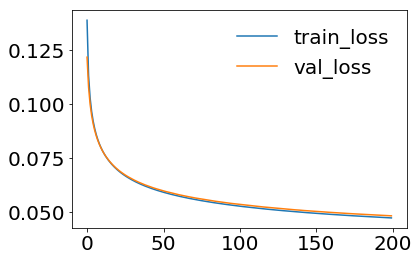

In [10]:
with open('./pickles/keras.pkl', 'rb') as f:
    keras = pickle.load(f)

plt.plot(range(200), keras['hist']['loss'], label='train_loss')
plt.plot(range(200), keras['hist']['val_loss'], label='val_loss')
plt.legend()
plt.show()

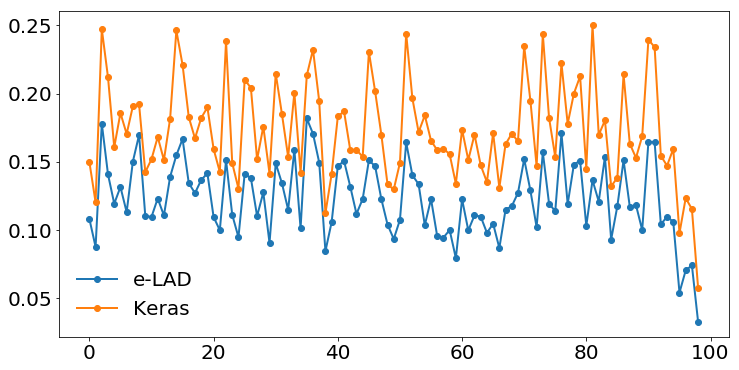

In [11]:
with open('./pickles/keras.pkl', 'rb') as f:
    keras = pickle.load(f)
    
with open('./pickles/LAD_(99,99)_ttv.pkl', 'rb') as f:
    lad = pickle.load(f)

plt.figure(figsize=(12,6))
plt.plot(range(99), lad['ferror'], 'o-', linewidth=2, label='e-LAD')
plt.plot(range(99), keras['ferror'], 'o-', linewidth=2, label='Keras')
plt.legend()
plt.show()

In [12]:
mae_keras = np.sum(np.abs(keras['pred'] - keras['obs']))/keras['pred'].size

w = np.zeros((4950,99))
bias = np.zeros(99)
for k in range(990):
    i = int(k/10)
    with open('./pickles/res/res_%s.pkl' % k, 'rb') as f:
        res = pickle.load(f)
    w[:,i:(i+1)] += res[0]
    bias[i] += res[1]
w = w/10
bias = bias/10

yp = all_init[val] + bias + quad_v.dot(w)
ya = all_init[val] + y_v
yp[yp < 0] = 0

mae_LAD = np.sum(np.abs(yp-ya))/yp.size

print(mae_keras, mae_LAD)

0.04797096925952974 0.0343029587507875


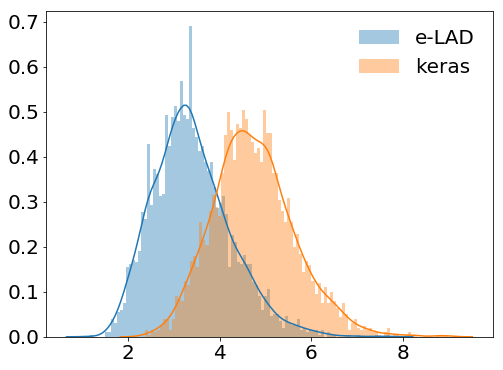

In [13]:
import seaborn as sns

    
plt.figure(figsize=(8,6))
sns.distplot(np.sum(np.abs(yp - ya), axis=1), bins=100, label='e-LAD')
sns.distplot(np.sum(np.abs(keras['pred'] - keras['obs']), axis=1), bins=100, label='keras')
plt.legend()
plt.show()

In [14]:
# model = Sequential()
# model.add(Dense(50000, activation='linear', use_bias=True, input_dim=4950))
# model.add(Dense(99, activation='linear'))
# model.compile(optimizer='SGD', loss='mean_absolute_error')
# hist = model.fit(quad_t, y_t, batch_size=100, epochs=20, validation_data=(quad_v, y_v), verbose=1)

# yp = all_init[val] + model.predict(quad_v)
# yp[yp<0] = 0
# ya = all_init[val] + y_v

# ferror = np.sum(np.abs(yp-ya), axis=0)/np.sum(np.abs(ya), axis=0)

# res = {'pred': yp,
#        'obs': ya,
#       'ferror': ferror,
#       'hist': hist.history}

# with open('./pickles/keras_hidden.pkl', 'wb') as f:
#     pickle.dump(res,f)

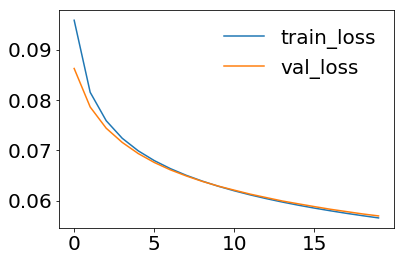

In [15]:
with open('./pickles/keras_hidden.pkl', 'rb') as f:
    keras = pickle.load(f)

plt.plot(range(20), keras['hist']['loss'], label='train_loss')
plt.plot(range(20), keras['hist']['val_loss'], label='val_loss')
plt.legend()
plt.show()

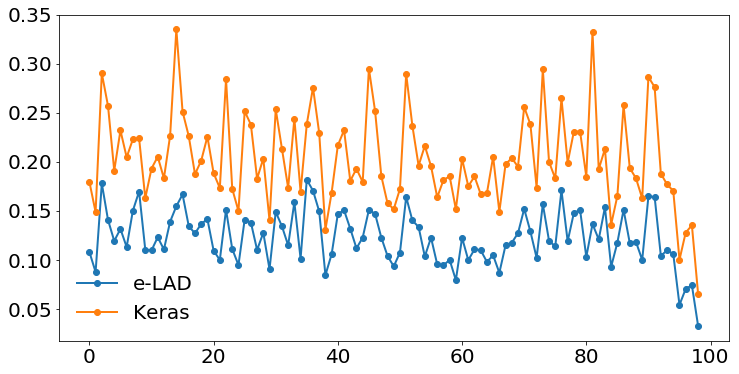

In [16]:
with open('./pickles/LAD_(99,99)_ttv.pkl', 'rb') as f:
    lad = pickle.load(f)

plt.figure(figsize=(12,6))
plt.plot(range(99), lad['ferror'], 'o-', linewidth=2, label='e-LAD')
plt.plot(range(99), keras['ferror'], 'o-', linewidth=2, label='Keras')
plt.legend()
plt.show()

In [17]:
mae_keras = np.sum(np.abs(keras['pred'] - keras['obs']))/keras['pred'].size

w = np.zeros((4950,99))
bias = np.zeros(99)
for k in range(990):
    i = int(k/10)
    with open('./pickles/res/res_%s.pkl' % k, 'rb') as f:
        res = pickle.load(f)
    w[:,i:(i+1)] += res[0]
    bias[i] += res[1]
w = w/10
bias = bias/10

yp = all_init[val] + bias + quad_v.dot(w)
ya = all_init[val] + y_v
yp[yp < 0] = 0
mae_LAD = np.sum(np.abs(yp-ya))/yp.size

print(mae_keras, mae_LAD)

0.05686444736846375 0.0343029587507875


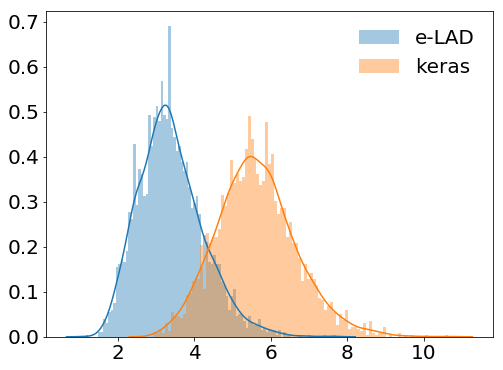

In [18]:
import seaborn as sns

    
plt.figure(figsize=(8,6))
sns.distplot(np.sum(np.abs(yp - ya), axis=1), bins=100, label='e-LAD')
sns.distplot(np.sum(np.abs(keras['pred'] - keras['obs']), axis=1), bins=100, label='keras')
plt.legend()
plt.show()